In [1]:
# *****************************************************************************
#
#
# Purpose: Calibration of the 3-State Cancer Relative Survival (CRS) 
#          Markov Model using random search with Latin Hypercube Sampling
#
# Authors: 
# This work is developed by the Decision Analysis in R for Technologies in Health 
# (DARTH) workgroup:
#
# - Fernando Alarid-Escudero, PhD
# - Eva A. Enns, MS, PhD 
# - M.G. Myriam Hunink, MD, PhD 
# - Hawre J. Jalal, MD, PhD 
# - Eline Krijkamp, PhD 
# - Petros Pechlivanoglou, PhD
# - Alan Yang, MSc
#
# *****************************************************************************
#
# Notes:
#
# Please acknowledge our work. See details to cite below:
#
# - Alarid-Escudero F, MacLehose RF, Peralta Y, Kuntz KM, Enns EA. 
#   Non-identifiability in model calibration and implications for 
#   medical decision making. Med Decis Making. 2018; 38(7):810-821.
#
# - Jalal H, Pechlivanoglou P, Krijkamp E, Alarid-Escudero F, Enns E, 
#   Hunink MG. An Overview of R in Health Decision Sciences. 
#   Med Decis Making. 2017; 37(3): 735-746.
#
# A walkthrough of the code could be found in the following link:
# - https://darth-git.github.io/calibSMDM2018-materials/
#
# *****************************************************************************

# ******************************************************************************
# 01 Calibration Overview ------------------------------------------------------
# ******************************************************************************

### 01.01 Model description  ---------------------------------------------------
# Model: 3-State Cancer Relative Survival (CRS) Markov Model
# Inputs to be calibrated: p_Mets, p_DieMets
# Targets: Survival data

### 01.02 Calibration method  --------------------------------------------------
# Search method: Random search using Latin Hypercube Sampling
# Goodness-of-fit measure: Sum of log-likelihoods

In [2]:
# ******************************************************************************
# 02 Setup ---------------------------------------------------------------------
# ******************************************************************************

### 02.01 Clear environment  ---------------------------------------------------
rm(list = ls())

### 02.02 Load packages  -------------------------------------------------------
# Install pacman if not present
if (!requireNamespace("pacman", quietly = TRUE)) install.packages("pacman")

# Load pacman
library(pacman)

# Load (install if needed) CRAN packages
p_load(
  lhs,          # Latin Hypercube Sampling
  plotrix,      # Plotting with confidence intervals
  psych         # Pairs panels
)

Installing package into ‘/home/giparra/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/giparra/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)


lhs installed

Installing package into ‘/home/giparra/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)


plotrix installed

Installing package into ‘/home/giparra/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mnormt’, ‘GPArotation’



psych installed



In [5]:
# ******************************************************************************
# 03 Load calibration targets --------------------------------------------------
# ******************************************************************************

### 03.01 Load target data  ----------------------------------------------------
load("../../data/CRS_CalibTargets.RData")
lst_targets <- CRS_targets

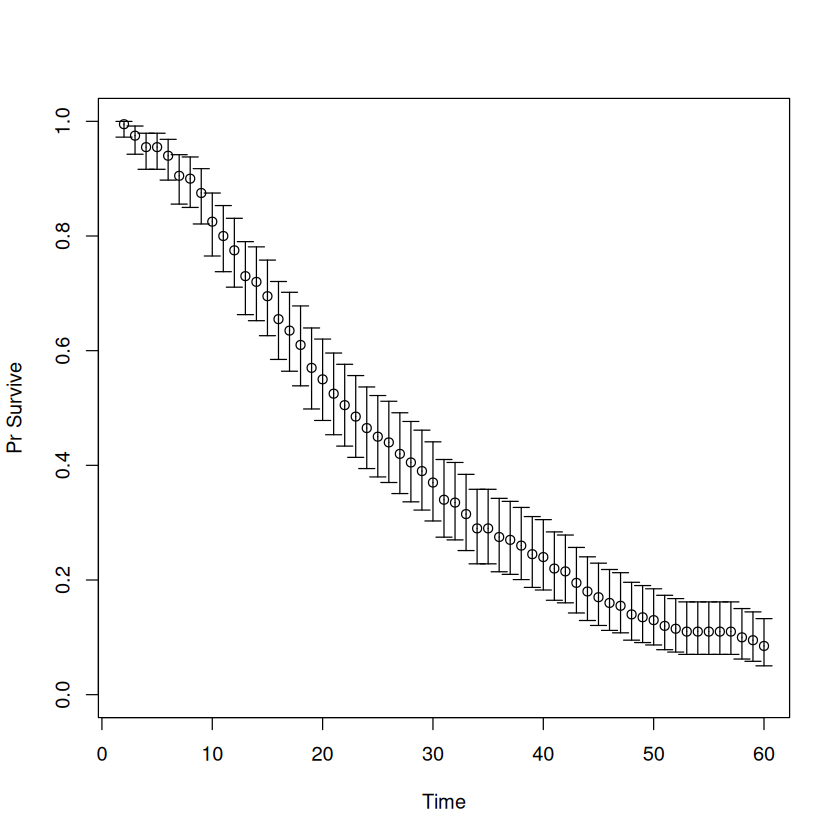

In [6]:
### 03.02 Visualize calibration targets  ---------------------------------------
# TARGET 1: Survival ("Surv")
plotrix::plotCI(x = lst_targets$Surv$time, 
                y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", 
                ylab = "Pr Survive")

# TARGET 2: (if you had more...)
# plotrix::plotCI(x = lst_targets$Target2$time, y = lst_targets$Target2$value, 
#                 ui = lst_targets$Target2$ub,
#                 li = lst_targets$Target2$lb,
#                 ylim = c(0, 1), 
#                 xlab = "Time", ylab = "Target 2")

In [8]:
# ******************************************************************************
# 04 Load model as a function --------------------------------------------------
# ******************************************************************************

### 04.01 Source model function  -----------------------------------------------
# Function inputs: parameters to be estimated through calibration
# Function outputs: model predictions corresponding to target data
source("../../code/Functions/CRS_MarkovModel_Function.R") # creates run_crs_markov()
### 04.02 Test model function  -------------------------------------------------
v_params_test <- c(p_Mets = 0.10, p_DieMets = 0.05)
run_crs_markov(v_params_test) # Test: function works correctly

$Surv
         2          3          4          5          6          7          8 
0.99500000 0.98575000 0.97291250 0.95707188 0.93874278 0.91837769 0.89637365 
         9         10         11         12         13         14         15 
0.87307833 0.84879544 0.82378959 0.79829064 0.77249758 0.74658203 0.72069133 
        16         17         18         19         20         21         22 
0.69495132 0.66946885 0.64433400 0.61962203 0.59539519 0.57170426 0.54859000 
        23         24         25         26         27         28         29 
0.52608435 0.50421161 0.48298935 0.46242937 0.44253844 0.42331901 0.40476980 
        30         31         32         33         34         35         36 
0.38688637 0.36966161 0.35308613 0.33714867 0.32183639 0.30713521 0.29303003 
        37         38         39         40         41         42         43 
0.27950495 0.26654348 0.25412871 0.24224343 0.23087030 0.21999193 0.20959096 
        44         45         46         47         48         49         50 
0.19965017 0.19015255 0.18108132 0.17242001 0.16415250 0.15626300 0.14873618 
        51         52         53         54         55         56         57 
0.14155706 0.13471112 0.12818429 0.12196293 0.11603386 0.11038433 0.10500206 
        58         59         60 
0.09987521 0.09499237 0.09034259

In [9]:
# ******************************************************************************
# 05 Calibration specifications ------------------------------------------------
# ******************************************************************************

### 05.01 Set random seed  -----------------------------------------------------
set.seed(072218) # For reproducible sequence of random numbers

### 05.02 Define calibration parameters  ---------------------------------------
# Number of random samples
n_samp <- 1000

# Names and number of parameters to calibrate
v_param_names <- c("p_Mets", "p_DieMets")
n_param       <- length(v_param_names)

# Search space bounds
lb <- c(p_Mets = 0.04, p_DieMets = 0.04) # lower bound
ub <- c(p_Mets = 0.16, p_DieMets = 0.16) # upper bound

### 05.03 Define calibration targets  ------------------------------------------
v_target_names <- c("Surv")
n_target       <- length(v_target_names)

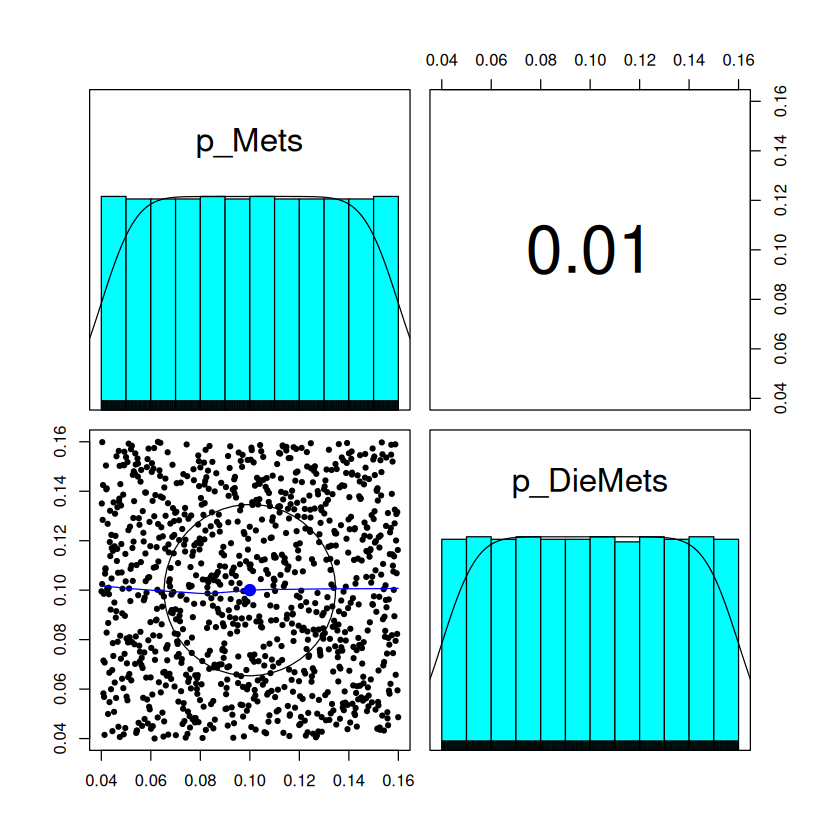

In [10]:
# ******************************************************************************
# 06 Run calibration using Latin Hypercube Sampling ----------------------------
# ******************************************************************************

### 06.01 Record start time  ---------------------------------------------------
t_init <- Sys.time()

### 06.02 Generate random sample of parameter values  --------------------------
# Sample unit Latin Hypercube
m_lhs_unit <- randomLHS(n_samp, n_param)

# Rescale to min/max of each parameter
m_param_samp <- matrix(nrow = n_samp, ncol = n_param)
for (i in 1:n_param) {
  m_param_samp[, i] <- qunif(m_lhs_unit[, i],
                             min = lb[i],
                             max = ub[i])
}
colnames(m_param_samp) <- v_param_names

# View resulting parameter set samples
pairs.panels(m_param_samp)

### 06.03 Run model for each set of parameter values  --------------------------
# Initialize goodness-of-fit matrix
m_GOF <- matrix(nrow = n_samp, ncol = n_target)
colnames(m_GOF) <- paste0(v_target_names, "_fit")

# Loop through sampled sets of input values
for (j in 1:n_samp) { # j <- 1
  
  # Run model for a given parameter set
  model_res <- run_crs_markov(v_params = m_param_samp[j, ])
  
  # Calculate goodness-of-fit of model outputs to targets
  
  # TARGET 1: Survival ("Surv")
  # Log likelihood  
  m_GOF[j, 1] <- sum(dnorm(x = lst_targets$Surv$value,
                           mean = model_res$Surv,
                           sd = lst_targets$Surv$se,
                           log = T))
  
  # weighted sum of squared errors (alternative to log likelihood)
  # w <- 1/(lst_targets$Surv$se^2)
  # m_GOF[j,1] <- -sum(w*(lst_targets$Surv$value - v_res)^2)
  
  # TARGET 2: (if you had more...)
  # log likelihood
  # m_GOF[j,2] <- sum(dnorm(x = lst_targets$Target2$value,
  #                        mean = model_res$Target2,
  #                        sd = lst_targets$Target2$se,
  #                        log = T))
  
} # End loop over sampled parameter sets

In [11]:
### 06.04 Combine fits to different targets into single GOF  -------------------
# Can give different targets different weights
v_weights <- matrix(1, nrow = n_target, ncol = 1)

# Matrix multiplication to calculate weighted sum of each GOF matrix row
v_GOF_overall <- c(m_GOF %*% v_weights)

# Store in GOF matrix with column name "Overall"
m_GOF <- cbind(m_GOF, Overall_fit = v_GOF_overall)

### 06.05 Calculate computation time  ------------------------------------------
comp_time <- Sys.time() - t_init

# ******************************************************************************
# 07 Explore best-fitting parameter sets ---------------------------------------
# ******************************************************************************

### 07.01 Sort results by goodness-of-fit  -------------------------------------
# Arrange parameter sets in order of fit
m_calib_res <- cbind(m_param_samp, m_GOF)
m_calib_res <- m_calib_res[order(-m_calib_res[, "Overall_fit"]), ]

### 07.02 Examine top-performing parameter sets  -------------------------------
# Examine the top 10 best-fitting sets
m_calib_res[1:10, ]

p_Mets,p_DieMets,Surv_fit,Overall_fit
0.12064380,0.04876755,155.9809,155.9809
0.13074497,0.04738415,155.8150,155.8150
0.11621296,0.04978729,155.7469,155.7469
0.04648278,0.13351470,155.6605,155.6605
0.04972425,0.11464422,155.6435,155.6435
0.11610324,0.04922040,155.6220,155.6220
0.13211690,0.04753830,155.3979,155.3979
0.11086387,0.05092722,155.3118,155.3118
0.04715960,0.13585226,154.9400,154.9400
0.05183553,0.10862779,154.8143,154.8143


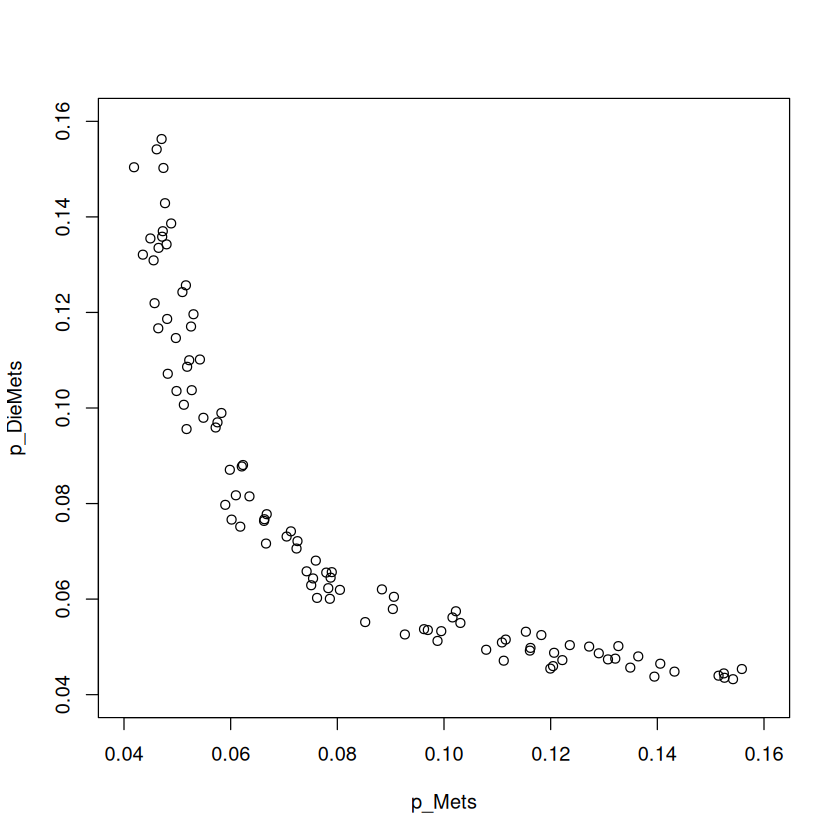

In [12]:
### 07.03 Visualize top-performing parameter sets  -----------------------------
# Plot the top 100 (top 10%)
plot(m_calib_res[1:100, 1], m_calib_res[1:100, 2],
     xlim = c(lb[1], ub[1]), ylim = c(lb[2], ub[2]),
     xlab = colnames(m_calib_res)[1],
     ylab = colnames(m_calib_res)[2])

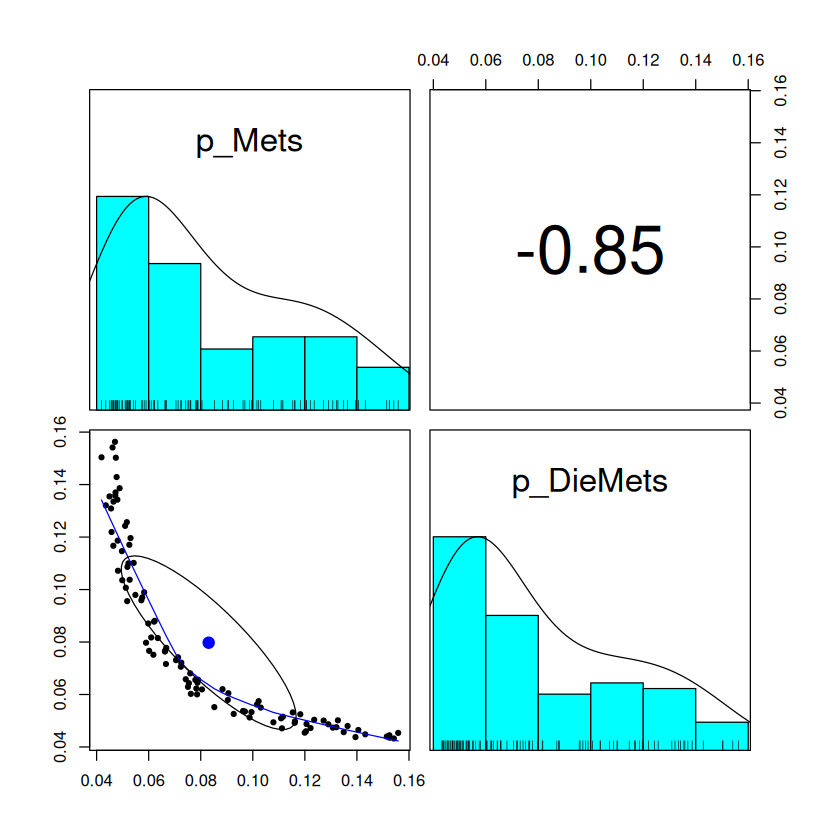

In [13]:
# Pairwise comparison of top 100 sets
pairs.panels(m_calib_res[1:100, v_param_names])

### 07.04 Compare best and worst fit model outputs to targets  -----------------
# Plot model-predicted output at best and worst set vs targets
v_out_best  <- run_crs_markov(m_calib_res[1, ])
v_out_worst <- run_crs_markov(m_calib_res[999, ])

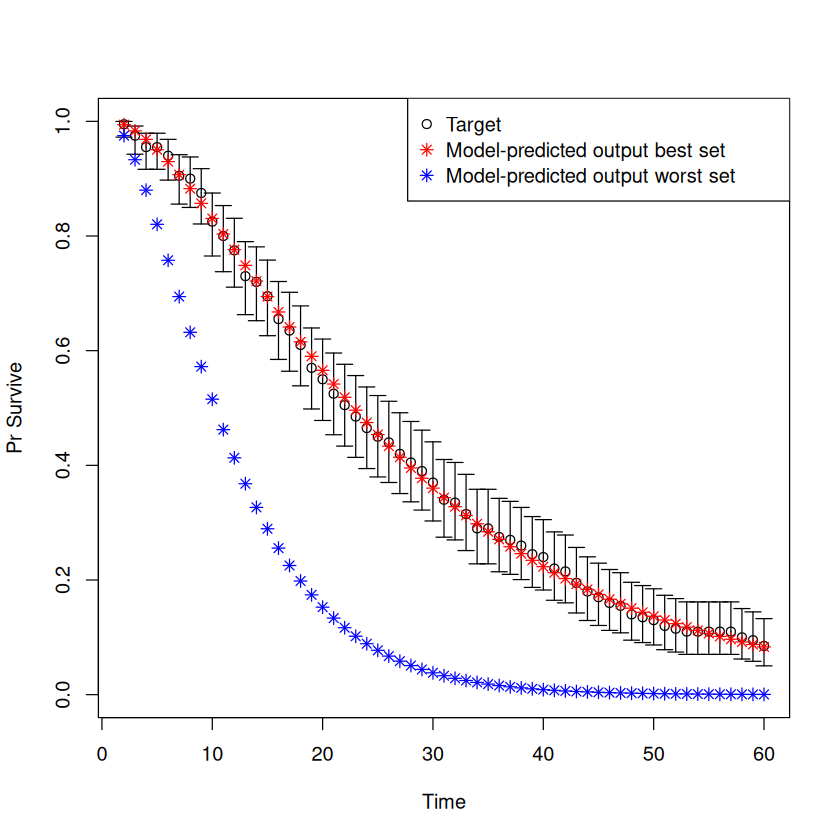

In [14]:
# TARGET 1: Survival ("Surv")
plotrix::plotCI(x = lst_targets$Surv$time, y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", ylab = "Pr Survive")
points(x = lst_targets$Surv$time, 
       y = v_out_best$Surv, 
       pch = 8, col = "red")
points(x = lst_targets$Surv$time, 
       y = v_out_worst$Surv, 
       pch = 8, col = "blue")
legend("topright", 
       legend = c("Target", 
                  "Model-predicted output best set", 
                  "Model-predicted output worst set"),
       col = c("black", "red", "blue"), pch = c(1, 8, 8))

In [ ]:
# TARGET 2: (if you had more...)
# plotrix::plotCI(x = lst_targets$Target2$time, y = lst_targets$Target2$value, 
#                 ui = lst_targets$Target2$ub,
#                 li = lst_targets$Target2$lb,
#                 ylim = c(0, 1), 
#                 xlab = "Time", ylab = "Target 2")
# points(x = lst_targets$Target2$time, 
#        y = v_out_best$Target2, 
#        pch = 8, col = "red")
# legend("topright", 
#        legend = c("Target", "Model-predicted output"),
#        col = c("black", "red"), pch = c(1, 8))

